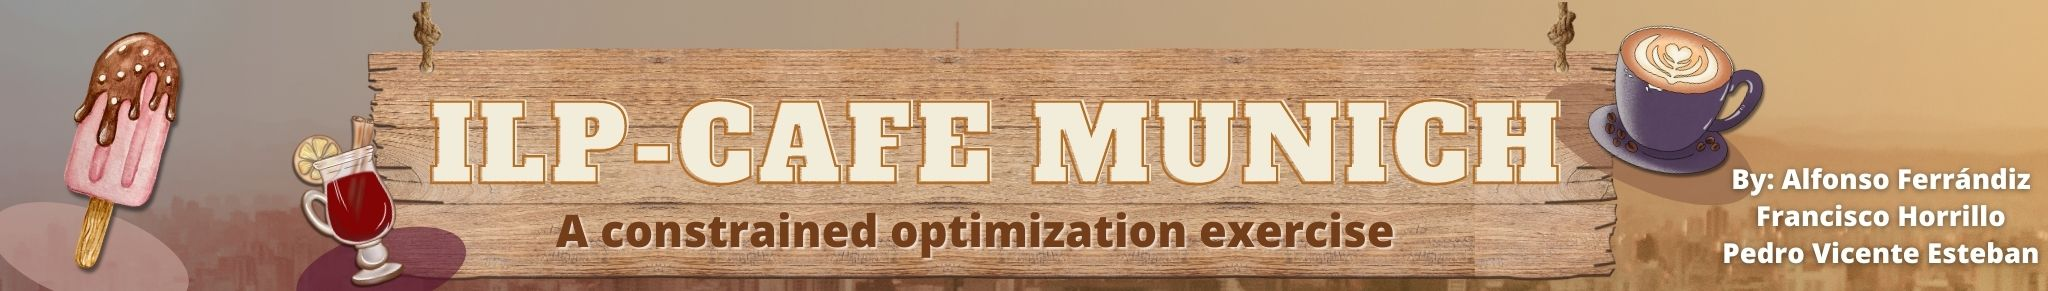

In [56]:
from IPython.display import Image
Image(filename='Q-Cafe Munich.jpg')

# <a id='toc1_'></a>[**Integer Constrained Optimization: A Munich Cafeteria**](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [**Integer Constrained Optimization: A Munich Cafeteria**](#toc1_)    
- [Problem  statement](#toc2_)    
- [Environment Preparation](#toc3_)    
- [Capturing the Weather Data](#toc4_)    
- [Time Series Analysis and Forecast](#toc5_)    
- [Integer constrained optimization applied to demand](#toc6_)    
- [Creating the Concrete Model](#toc7_)    
- [Pyomo Recommendations for Cafe owner](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Problem  statement](#toc0_)

Last week, we received a very interesting call. Helga, the owner of ILP-Cafe, located in Munich, contacted us, as she knew we were studying the Big Data Master and thought we could help her. This iconic coffee shop has been open for 20 years despite only selling 3 products: mulled wine, coffee and ice cream. 
The complexity of the problem is that Helga, has realized that the products have a high seasonality and therefore, it is very difficult to maximize profits by adapting the production capacity to the existing demand.

# <a id='toc3_'></a>[Environment Preparation](#toc0_)

In [57]:
#importing the needed libraries

import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
import random
import pmdarima as pm
import numpy as np
from datetime import *
import pyomo.environ as pyo
from pyomo.environ import *
from pandas import *
import os

# <a id='toc4_'></a>[Capturing the Weather Data](#toc0_)

Bringing the weather data to our model.

For this we have used https://openweathermap.org/ a website that provides weather API for several locations around the world. As a first step the historical data for the city of Munich will be obtained:

In [4]:
#Calculate one week ago weather (the end point does not allow to retrieve data for last 7 days)
yesterday = datetime.now() - timedelta(days=7)
end_date = yesterday.strftime("%Y-%m-%d")


#API call
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 48.14,
    "longitude": 11.58,
    "start_date": "2021-01-01",
    "end_date": end_date,
    "hourly": "temperature_2m"
}

response = requests.get(url, params=params)

#Getting hourly data into a dataframe
if response.status_code == 200:
    data = response.json()
    hourly_data = data['hourly']
    df = pd.DataFrame(hourly_data)
    
    #Splitting time into date and hour columns
    df[['date', 'hour']] = df['time'].str.split('T', expand=True)

    print(df)
else:
    print("Failed to retrieve data. Status code:", response.status_code)

                   time  temperature_2m        date   hour
0      2021-01-01T00:00            -1.6  2021-01-01  00:00
1      2021-01-01T01:00            -2.7  2021-01-01  01:00
2      2021-01-01T02:00            -2.2  2021-01-01  02:00
3      2021-01-01T03:00            -1.4  2021-01-01  03:00
4      2021-01-01T04:00            -1.1  2021-01-01  04:00
...                 ...             ...         ...    ...
21307  2023-06-07T19:00            19.1  2023-06-07  19:00
21308  2023-06-07T20:00            17.2  2023-06-07  20:00
21309  2023-06-07T21:00            15.9  2023-06-07  21:00
21310  2023-06-07T22:00            14.5  2023-06-07  22:00
21311  2023-06-07T23:00            13.5  2023-06-07  23:00

[21312 rows x 4 columns]


In [5]:
#Now, we drop with hour and with time columns, and also (just in case) rows with NaN values
df.drop(['hour', 'time'], axis=1, inplace=True)
df.dropna(inplace=True)

In [6]:
#We convert the 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

#Now, we group by date and we calculate mean temperature
df = df.groupby('date')['temperature_2m'].mean().reset_index()

print(df)

          date  temperature_2m
0   2021-01-01       -0.491667
1   2021-01-02       -0.625000
2   2021-01-03       -0.812500
3   2021-01-04       -0.912500
4   2021-01-05       -0.725000
..         ...             ...
883 2023-06-03       16.375000
884 2023-06-04       16.300000
885 2023-06-05       15.891667
886 2023-06-06       15.662500
887 2023-06-07       17.254167

[888 rows x 2 columns]


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            888 non-null    datetime64[ns]
 1   temperature_2m  888 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.0 KB


In [8]:
#Change temperature_2m column name to avg_temperature
df.rename(columns={'temperature_2m': 'avg_temperature'}, inplace=True)

Let's see how the weather behaves in Munich, and how seasonal it is.

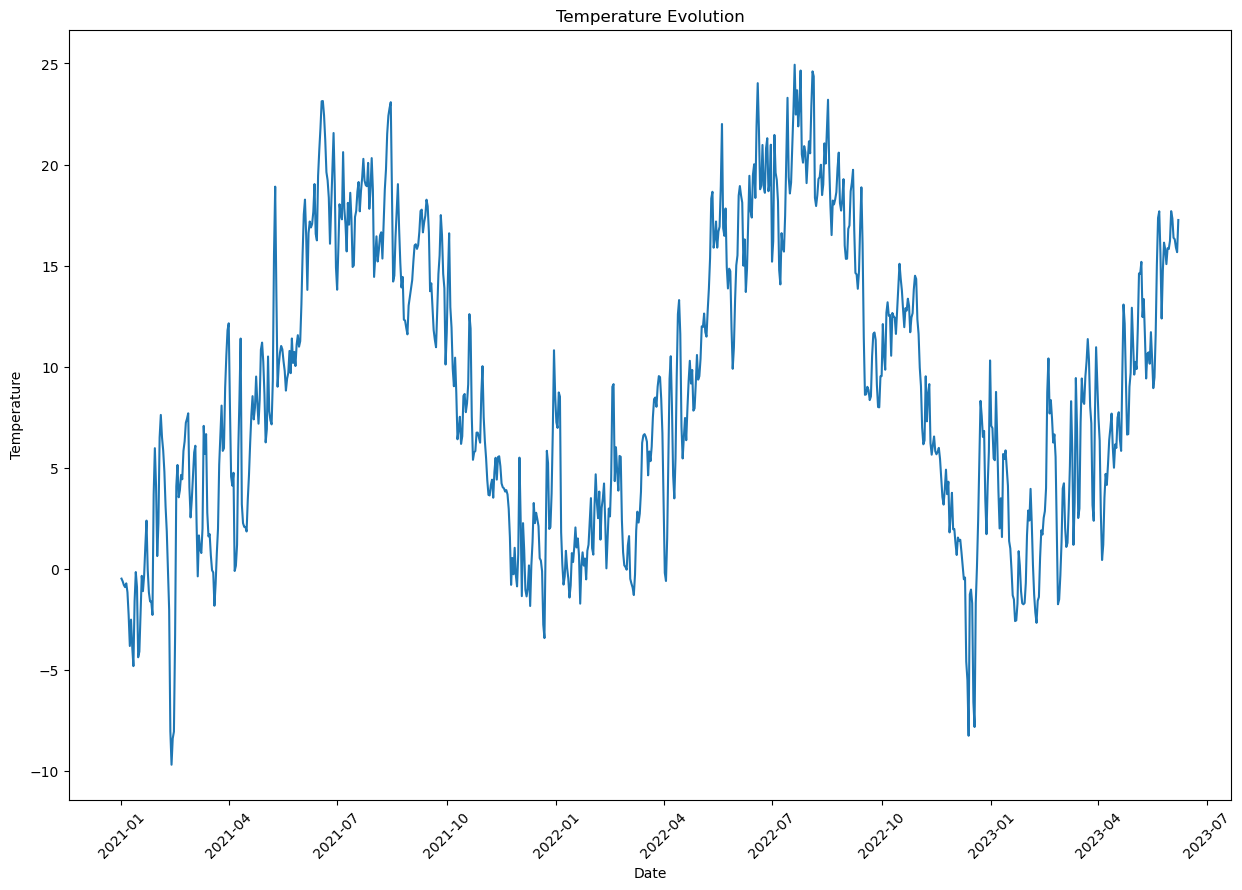

In [9]:
#Let's plot the temperature evolution in Munich
plt.figure(figsize=(15, 10))
plt.plot(df['date'], df['avg_temperature'])


# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Evolution')
plt.xticks(rotation=45)

# Display the plot
plt.show()

It can be seen that it does have a strong seasonality, so there is a prediction model that can be applied. 

# <a id='toc5_'></a>[Time Series Analysis and Forecast](#toc0_)

As the owner of ILP-Cafe Munich has told us, the demand for certain products depends a lot on the temperature, and it would be of immense help to know what it will be for the next 7 days. 

The problem is that, in her words, the weather programs are very wrong and always miss!!. Therefore, and after her insistence, we will develop a simple model to help us predict the temperature evolution for the next 7 days.

In [10]:
#We prepare a new df to work with time series
df_ts = df.copy()
df_ts.set_index('date', inplace=True)
df_ts.index.freq = 'D'
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 888 entries, 2021-01-01 to 2023-06-07
Freq: D
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_temperature  888 non-null    float64
dtypes: float64(1)
memory usage: 13.9 KB


In [11]:
#Splitting the data into train and test sets (the test set will be the last 3% of the data, and it is low because we just want to predict 14 days ahead)
train, validation = train_test_split(df_ts, test_size=0.03, shuffle=False)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 861 entries, 2021-01-01 to 2023-05-11
Freq: D
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_temperature  861 non-null    float64
dtypes: float64(1)
memory usage: 13.5 KB


In [13]:
train.head(10)

,avg_temperature
date,
2021-01-01,-0.491667
2021-01-02,-0.625000
2021-01-03,-0.812500
2021-01-04,-0.912500
2021-01-05,-0.725000
2021-01-06,-1.166667
2021-01-07,-2.295833
2021-01-08,-3.825000
2021-01-09,-2.520833


In [14]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27 entries, 2023-05-12 to 2023-06-07
Freq: D
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_temperature  27 non-null     float64
dtypes: float64(1)
memory usage: 432.0 bytes


In [15]:
validation.head(10)

,avg_temperature
date,
2023-05-12,10.637500
2023-05-13,10.704167
2023-05-14,10.141667
2023-05-15,11.704167
2023-05-16,10.412500
2023-05-17,8.933333
2023-05-18,9.466667
2023-05-19,11.583333
2023-05-20,15.025000


As we have said, our objective is not to develop an excellent model, since it is outside the contracted scope. For this reason, we will apply a simple **autoarima**

In [16]:
#First, we extract train temperature
y = train['avg_temperature']

#Fit an AutoARIMA model
model = pm.auto_arima(y, seasonal=False)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  861
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1718.085
Date:                Wed, 14 Jun 2023   AIC                           3448.170
Time:                        22:39:25   BIC                           3476.712
Sample:                    01-01-2021   HQIC                          3459.097
                         - 05-11-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0735      0.194     -0.380      0.704      -0.453       0.306
ar.L2          0.3405      0.154      2.206      0.027       0.038       0.643
ma.L1          0.2272      0.191      1.191      0.2

Now, we check how the model fits the data


In [17]:

#Extract the average temperature column from the validation DataFrame
validation_data = validation['avg_temperature']

#Generate forecasts
forecast, conf_int = model.predict(n_periods=len(validation_data), return_conf_int=True)

#Calculate MAPE
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

mape = calculate_mape(validation_data, forecast)

print(f"MAPE: {mape:.2f}%")


MAPE: 25.19%


Well, the error is significant...

But the cafe owner just said that it **will help her significantly**, as weather programs in the region miss more than 50%! So let's go ahead

Now, we know that the trained model is a SARIMA(2,1,3). For simplicity, we will apply autoarima, to the whole data, check that we find the same model, and make our predictions for the next 10 days.

In [18]:
#Extract the average temperature column for all the data
y = df_ts['avg_temperature']

#Fit an AutoARIMA model
model2 = pm.auto_arima(y, seasonal=False)

print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  888
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1766.150
Date:                Wed, 14 Jun 2023   AIC                           3544.301
Time:                        22:39:32   BIC                           3573.028
Sample:                    01-01-2021   HQIC                          3555.282
                         - 06-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0874      0.191     -0.458      0.647      -0.462       0.287
ar.L2          0.3415      0.152      2.248      0.025       0.044       0.639
ma.L1          0.2426      0.188      1.288      0.1

In [19]:
#Generate forecasts for the next 15 days (as we are missing the last 7 days, we will predict 15 days ahead)
forecast, conf_int = model2.predict(n_periods= 20, return_conf_int=True)

In [20]:
#Transform forecast into a DataFrame
forecast = pd.DataFrame(forecast, index=pd.date_range(start=df_ts.index[-1] + pd.DateOffset(days=1), periods=15, freq='D'), columns=['avg_temperature'])
forecast = forecast.iloc[1:]
forecast.reset_index(inplace=True)
forecast.rename(columns={'index': 'date'}, inplace=True)
forecast.head(15)

,date,avg_temperature
0,2023-06-09,17.136840
1,2023-06-10,16.783469
2,2023-06-11,16.673703
3,2023-06-12,16.562633
4,2023-06-13,16.534855
5,2023-06-14,16.499356
6,2023-06-15,16.492973
7,2023-06-16,16.481409
8,2023-06-17,16.480239
9,2023-06-18,16.476393


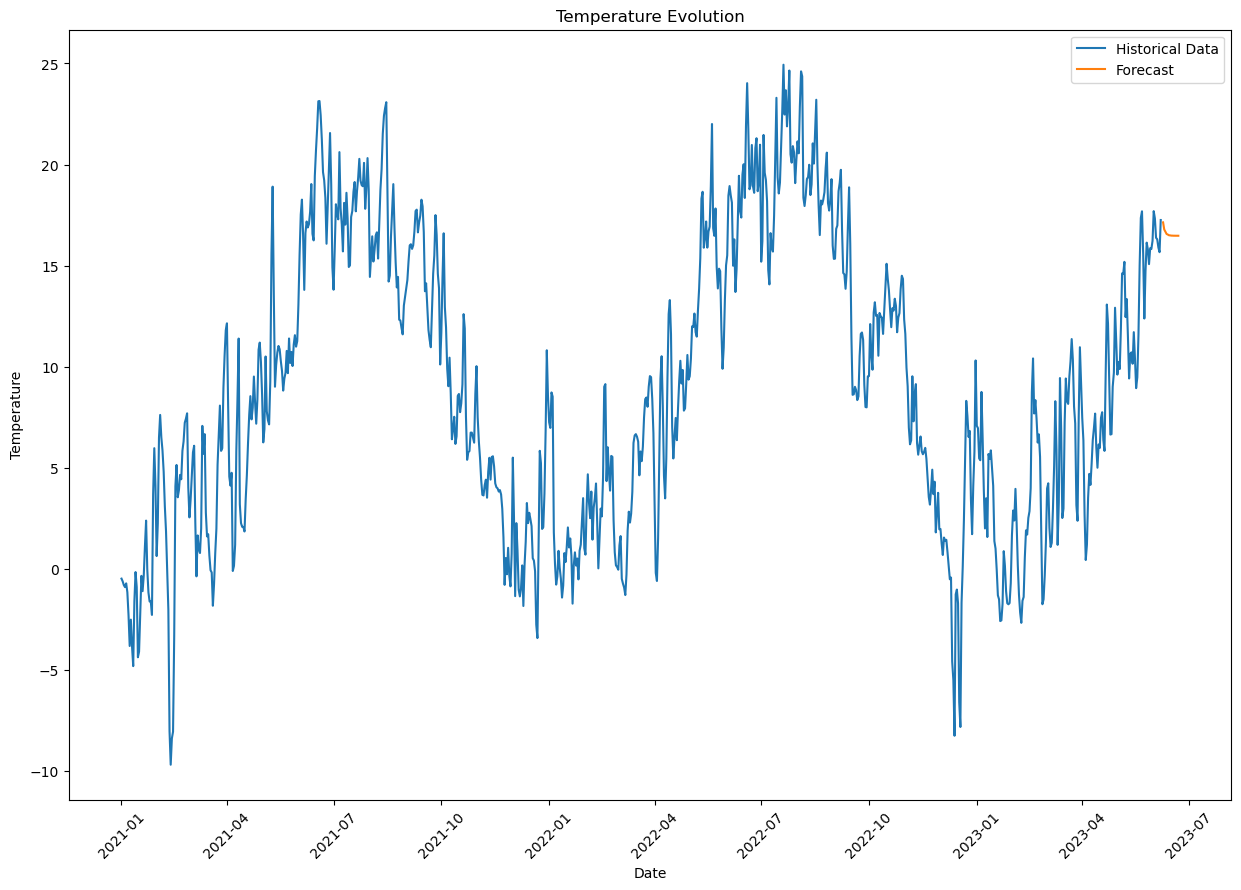

In [21]:
#plot df and forecast in the same linear graph
plt.figure(figsize=(15, 10))
plt.plot(df['date'], df['avg_temperature'], label='Historical Data')
plt.plot(forecast['date'], forecast['avg_temperature'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Evolution')
plt.xticks(rotation=45)
plt.legend()
plt.show()


As mentioned, our forecast is not capable of predicting strong fluctuations but it is working for this case. 

In [28]:
print(pd.__version__)

2.0.2


In [29]:
#append the forecast dataframe to the original dataframe
df = pd.concat([df, forecast], ignore_index=True)

In [30]:
df

,date,avg_temperature
0,2021-01-01,-0.491667
1,2021-01-02,-0.625000
2,2021-01-03,-0.812500
3,2021-01-04,-0.912500
4,2021-01-05,-0.725000
...,...,...
897,2023-06-18,16.476393
898,2023-06-19,16.476330
899,2023-06-20,16.475022
900,2023-06-21,16.475115


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             902 non-null    datetime64[ns]
 1   avg_temperature  902 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.2 KB


# <a id='toc6_'></a>[Integer constrained optimization applied to demand](#toc0_)

Based on the conversations we had with Frau Helga and looking at their sales record, she explained us how the demand for drinks changes.  Because of this we have created a function that will create demand values for the three types of drinks based on the following criteria:
- If it is too cold (less than 10 degrees), Germans like to drink mulled wine followed by coffee and very little ice cream
- If it is mild demand (between 10 and 20 degrees) clients will drink mostly coffee, demand for wine decreases with a small increment on ice cream consumption
- It it is too hot then sales are mostly ice cream followed by coffee and very little wine

This is how the function will look like:


In [33]:
def get_demands_by_temperature(temperature_celsius):
    global wine_demand
    global ice_cream_demand
    global coffee_demand
    
    if temperature_celsius <= 10:
        wine_demand = random.randint(70, 90)
        ice_cream_demand = random.randint(1, 10)
        coffee_demand = random.randint(50, 70)
    elif temperature_celsius > 10 and temperature_celsius <= 20:
        wine_demand = random.randint(20, 40)
        ice_cream_demand = random.randint(15, 25)
        coffee_demand = random.randint(70, 90)
    elif temperature_celsius > 20:
        wine_demand = random.randint(1, 10)
        ice_cream_demand = random.randint(70, 90)
        coffee_demand = random.randint(30, 50)

    return wine_demand, ice_cream_demand, coffee_demand

Applying the function to our historical records to assign the demand of products to our data frame:

In [34]:
# Apply the function to the DataFrame and create new columns for demand
df[['wine_demand', 'ice_cream_demand', 'coffee_demand']] = df['avg_temperature'].apply(lambda x: pd.Series(get_demands_by_temperature(x)))
print(df)

          date  avg_temperature  wine_demand  ice_cream_demand  coffee_demand
0   2021-01-01        -0.491667           75                 6             63
1   2021-01-02        -0.625000           75                10             67
2   2021-01-03        -0.812500           88                 9             51
3   2021-01-04        -0.912500           75                 8             52
4   2021-01-05        -0.725000           85                 1             67
..         ...              ...          ...               ...            ...
897 2023-06-18        16.476393           24                21             82
898 2023-06-19        16.476330           33                19             75
899 2023-06-20        16.475022           37                23             82
900 2023-06-21        16.475115           25                24             81
901 2023-06-22        16.474660           34                22             74

[902 rows x 5 columns]


How does it looks like:

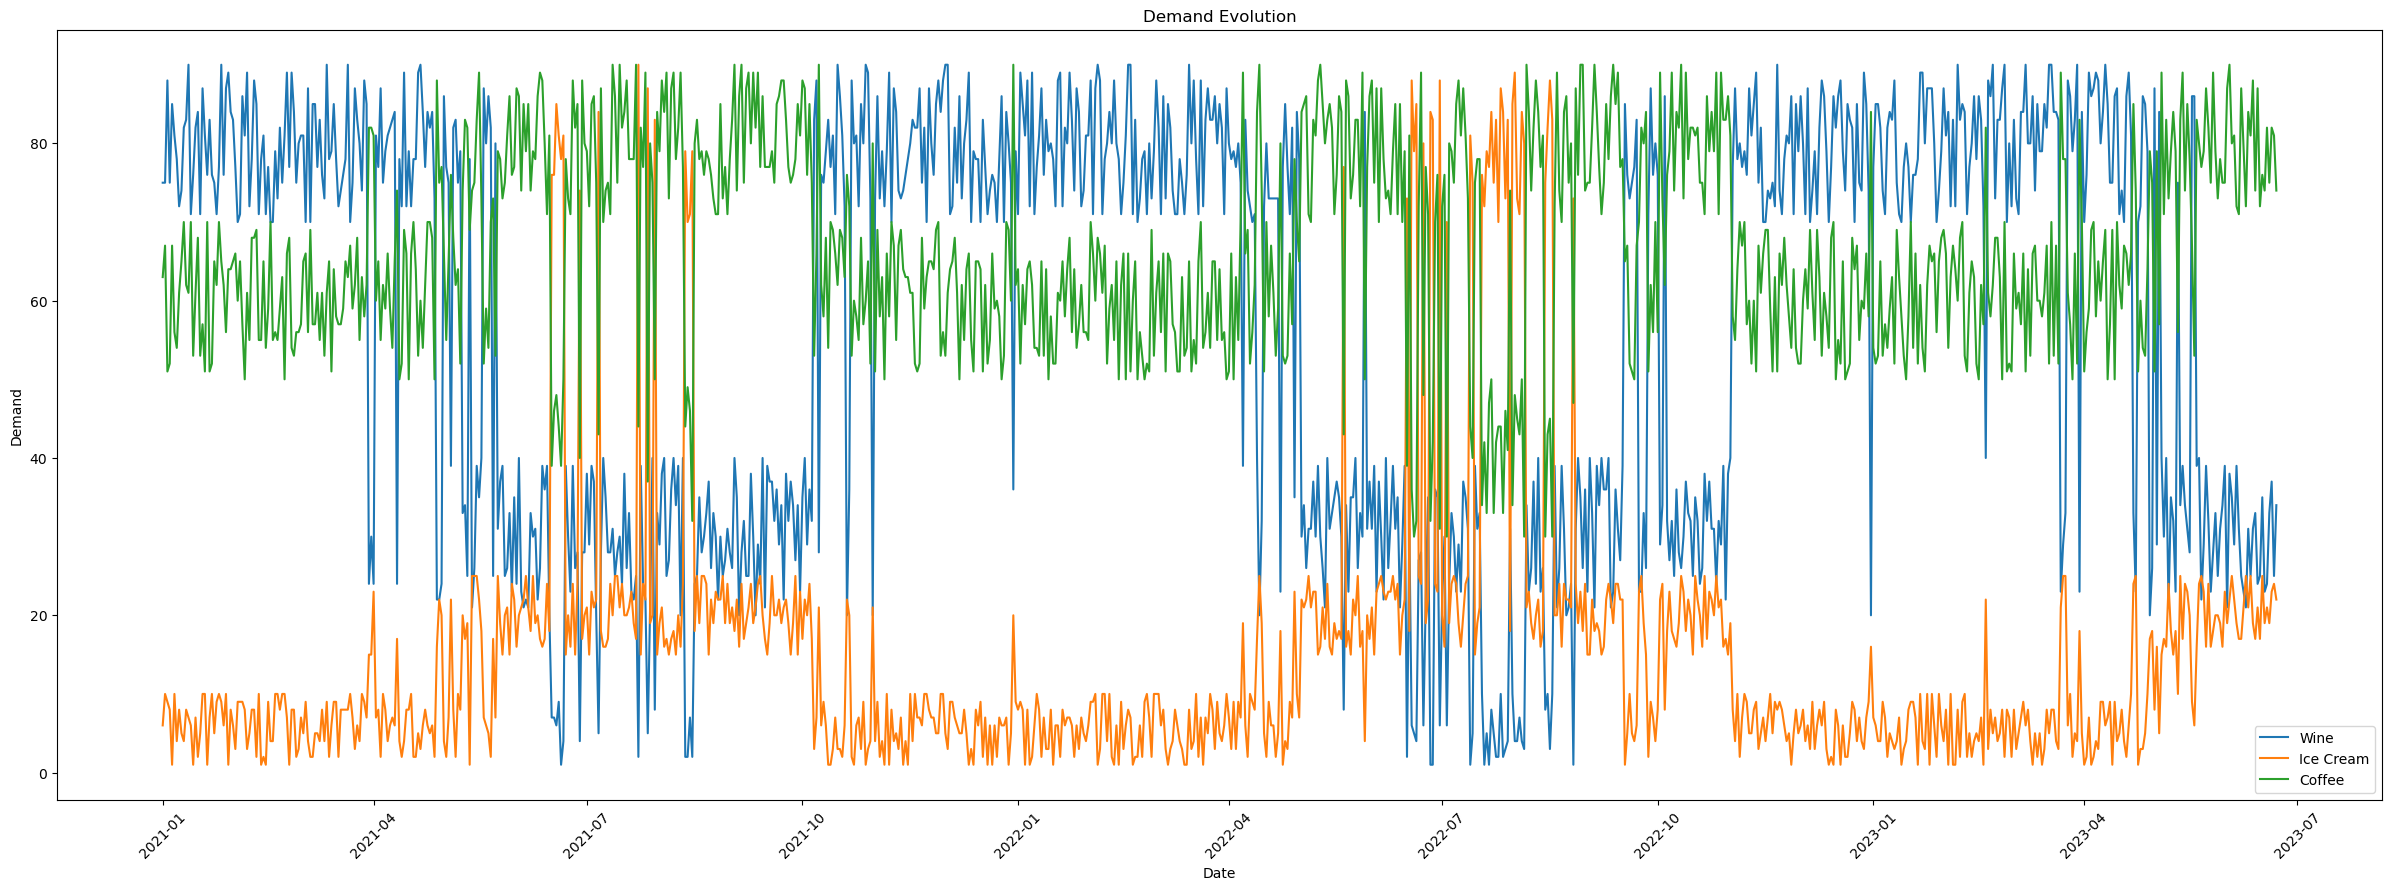

In [35]:
#Plot a linear graph with demand evolution for each product
plt.figure(figsize=(30, 10))
plt.plot(df['date'], df['wine_demand'], label='Wine')
plt.plot(df['date'], df['ice_cream_demand'], label='Ice Cream')
plt.plot(df['date'], df['coffee_demand'], label='Coffee')

plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Demand Evolution')
plt.xticks(rotation=45)
plt.legend()

plt.show()

Ok it is a bit complicated but we can clearly see seasonality for all the products and how it changes between them.

# <a id='toc7_'></a>[Creating the Concrete Model](#toc0_)

As a next step and to help Frau Helga, we have created an interface where she can introduce the dates to see how the demand is going to be, but be careful with the format!

In [36]:
#Input for the user to insert a date
date = input("Please, insert a date which is on the next 7 days or on the past (YYYY-MM-DD): ")

Ok! let's get this party started, time to run our predictions!

In [37]:
# Create a concrete model
model = pyo.ConcreteModel()

Setting up our concrete model with the following considerations:
- The values have to be always positive: she prepares the products on the spot and having negatives will not make much sense on this case
- No half portions: therefore the values have to be real

In [38]:
# create three variables for hot_wine, coffee and ice_cream with bounds between 0 and 100 which must be random
model.hot_wine = pyo.Var(within=pyo.NonNegativeReals, bounds=(0,100), initialize= wine_demand)
model.coffee = pyo.Var(within=pyo.NonNegativeReals, bounds=(0,100), initialize= coffee_demand)
model.ice_cream = pyo.Var(within=pyo.NonNegativeReals, bounds=(0,100), initialize= ice_cream_demand)

Now we can define our objective function, which represent the potential income. The prices are 2 euros for a hot wine, 1.5 euros for a coffee, and 3 euros for a delicious handmade ice-cream. We will maximise this function as we want to help Frau Helga to buy a new Volkswagen. 

In [40]:
#define the objective function, which will be maximize benefits
model.obj = pyo.Objective(expr = 2*model.hot_wine + 1.5*model.coffee + 3*model.ice_cream, sense = maximize)

In [41]:
#show the objective function
model.pprint()

3 Var Declarations
    coffee : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    74 :   100 : False : False : NonNegativeReals
    hot_wine : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    34 :   100 : False : False : NonNegativeReals
    ice_cream : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    22 :   100 : False : False : NonNegativeReals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 2*hot_wine + 1.5*coffee + 3*ice_cream

4 Declarations: hot_wine coffee ice_cream obj


Now, let's define our production constraints. The factors have been decided based on the capacity of the machines (basically, Helga) to produce one product or another, considering that she will spend the whole day producing just one product.

In [42]:
#capacity constraint for hot_wine and ice_cream and coffee
model.hot_wine_con = pyo.Constraint(expr = model.hot_wine <= 120)
model.coffee_con = pyo.Constraint(expr = model.coffee <= 200)
model.ice_cream_con = pyo.Constraint(expr = model.ice_cream <= 70)

And now, despite Helga could produce all the products she wants, she has to take into account the demand. Therefore, we have to define the demand constraints, that we have previously identify thanks to our useful prediction model.

In [43]:
#demand constrains for hot_wine, coffee and ice_cream
model.hot_wine_demand_con = pyo.Constraint(expr = model.hot_wine <= (wine_demand))
model.coffee_con2 = pyo.Constraint(expr = model.coffee <= (coffee_demand))
model.ice_cream_con2 = pyo.Constraint(expr = model.ice_cream <= (ice_cream_demand))

In [44]:
instance = model.create_instance()  # Create a concrete instance of the model

# <a id='toc8_'></a>[Pyomo Recommendations for Cafe owner](#toc0_)

So everything looks good so far, now lets solve it and se what is it that works best for Helga based on the day she has chosen:

In [48]:
#create different solvers and solve the model
opt = SolverFactory('cbc')
results = opt.solve(instance) # solves and updates instance
instance.display() # display solution
  


Model unknown

  Variables:
    hot_wine : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  34.0 :   100 : False : False : NonNegativeReals
    coffee : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  74.0 :   100 : False : False : NonNegativeReals
    ice_cream : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  22.0 :   100 : False : False : NonNegativeReals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 245.0

  Constraints:
    hot_wine_con : Size=1
        Key  : Lower : Body : Upper
        None :  None : 34.0 : 120.0
    coffee_con : Size=1
        Key  : Lower : Body : Upper
        None :  None : 74.0 : 200.0
    ice_cream_con : Size=1
        Key  : Lower : Body : Upper
        None :  None : 22.0 :  70.0
    hot_wine_demand_con : Size=1
        Ke

In [52]:
# <a id='toc8_'></a>[print the values of the variables](#toc0_)
print("Cafe Munich sales for hot wine are estimated at: " + str(pyo.value(instance.hot_wine)))
print("Cafe Munich sales for coffee are estimated at: " + str(pyo.value(instance.coffee)))
print("Cafe Munich sales for ice cream are estimated at: " + str(pyo.value(instance.ice_cream)))
print("--------------------------------------------------")

# <a id='toc9_'></a>[print the values of the objective function](#toc0_)
print("Cafe Munich will sell for today a grand total of:  " + str(pyo.value(instance.obj)))

Cafe Munich sales for hot wine are estimated at: 34.0
Cafe Munich sales for coffee are estimated at: 74.0
Cafe Munich sales for ice cream are estimated at: 22.0
--------------------------------------------------
Cafe Munich will sell for today a grand total of:  245.0


In [53]:
#use  using AbstractModel.create_instance() or AbstractScalarVar.construct() to create a concrete instance of the model
opt = SolverFactory('glpk') #select solver
results = opt.solve(instance) #solve the problem
instance.display() #display the results
# Print the results of the optimization problem
# <a id='toc8_'></a>[print the values of the variables](#toc0_)


Model unknown

  Variables:
    hot_wine : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  34.0 :   100 : False : False : NonNegativeReals
    coffee : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  74.0 :   100 : False : False : NonNegativeReals
    ice_cream : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  22.0 :   100 : False : False : NonNegativeReals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 245.0

  Constraints:
    hot_wine_con : Size=1
        Key  : Lower : Body : Upper
        None :  None : 34.0 : 120.0
    coffee_con : Size=1
        Key  : Lower : Body : Upper
        None :  None : 74.0 : 200.0
    ice_cream_con : Size=1
        Key  : Lower : Body : Upper
        None :  None : 22.0 :  70.0
    hot_wine_demand_con : Size=1
        Ke

In [54]:
print("Cafe Munich sales for hot wine are estimated at: " + str(pyo.value(instance.hot_wine)))
print("Cafe Munich sales for coffee are estimated at: " + str(pyo.value(instance.coffee)))
print("Cafe Munich sales for ice cream are estimated at: " + str(pyo.value(instance.ice_cream)))
#print a massive line separator
print("--------------------------------------------------")
print("Cafe Munich will sell for today a grand total of:  " + str(pyo.value(instance.obj)))

Cafe Munich sales for hot wine are estimated at: 34.0
Cafe Munich sales for coffee are estimated at: 74.0
Cafe Munich sales for ice cream are estimated at: 22.0
--------------------------------------------------
Cafe Munich will sell for today a grand total of:  245.0


Now Helga can planify with her suppliers and prepare the day in advance to make her German customers much happier showcasing her efficiency

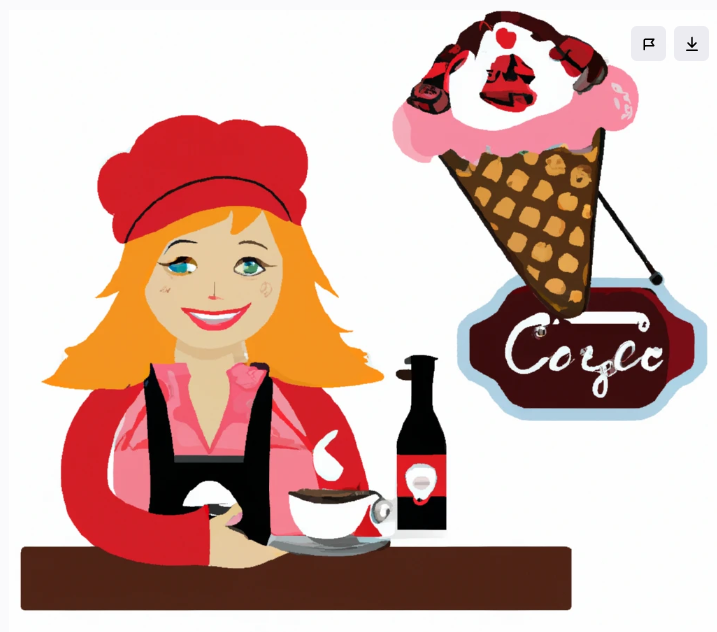

In [58]:
#export notebook to html
os.system('jupyter nbconvert --to html cafe_munich.ipynb')
 

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'Cafe_Munich.ipynb' matched no files


65280

Notebook partially created with DALL-E and Copilot 